In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset

# default plotting settings
#plt.rc('figure', figsize=(8.27,11.69))  # din a4 size in inches

# Anomalies Maps

This notebook visualises **temperature** and **precipitation** anomalies for Europe and Northern Africa. I wish to plot quite recent data (December 2020 to August 2021), hence, I can't use [CRU TS](https://doi.org/10.1038/s41597-020-0453-3). Alternatively, the [ERA5](https://climatedataguide.ucar.edu/climate-data/era5-atmospheric-reanalysis) (atmospheric reanalysis) contains both temperature and precipitation data and is available until 2021/12. The dataset can be downloaded from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home).

In [2]:
# load data from netCDF file
era5_file = Dataset('../../data/ERA5/era5_global_tmp-pre_2020-21.nc')
print(era5_file)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2022-03-17 18:07:08 GMT by grib_to_netcdf-2.24.2: /opt/ecmwf/mars-client/bin/grib_to_netcdf -S param -o /cache/data5/adaptor.mars.internal-1647540411.612724-27331-10-e990a460-af27-4214-be71-4a7f10c1d599.nc /cache/tmp/e990a460-af27-4214-be71-4a7f10c1d599-adaptor.mars.internal-1647540375.5522451-27331-10-tmp.grib
    dimensions(sizes): longitude(3600), latitude(1801), time(24)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 t2m(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 


In [3]:
# variable information
cru_vars = [var for var in era5_file.variables]
for var in cru_vars:
    print('variable:', era5_file.variables[var],'\n')

variable: <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (3600,)
filling on, default _FillValue of 9.969209968386869e+36 used 

variable: <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (1801,)
filling on, default _FillValue of 9.969209968386869e+36 used 

variable: <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (24,)
filling on, default _FillValue of -2147483647 used 

variable: <class 'netCDF4._netCDF4.Variable'>
int16 t2m(time, latitude, longitude)
    scale_factor: 0.0016708768689444869
    add_offset: 260.2578239243585
    _FillValue: -32767
    missing_value: -32767
    units: K
    long_name: 2 metre temperature
unlimited dimensions: 
current

In [4]:
# get the data
# NOTE: for now taking every 10th coord
t2m = era5_file.variables['t2m'][:,::10,::10]
lon = era5_file.variables['longitude'][::10]
lat = era5_file.variables['latitude'][::10]
print(t2m.shape)
print(lon.shape) # from -180 to 179
print(lat.shape) # from -90 to 90 (including 0°)

(24, 181, 360)
(360,)
(181,)


In [5]:
# import time var & convert into datetime object
time = era5_file.variables['time'][:]

from datetime import datetime, timedelta
dtime = []
start = datetime(1900, 1, 1)
for t in time:
    delta = timedelta(hours=int(t))
    dtime.append(start + delta)

In [6]:
# compute anomalies
# reference period: 2000-2020
# TODO: anomalies, colormap
anomaly_per_month = 0

In [7]:
# create array holding INDICES of vals of appropriate time frame
# NOTE: start and end date are both included!
start = datetime(2020, 12, 1)
end = datetime(2021, 8, 1)

iplot = []
for i, time in enumerate(dtime):
    if time >= start and time <= end:
        iplot.append(i)
iplot

[11, 12, 13, 14, 15, 16, 17, 18, 19]

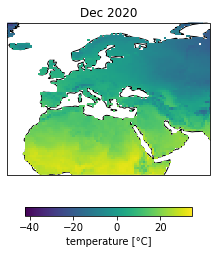

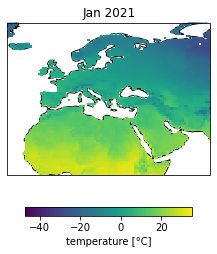

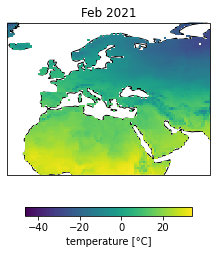

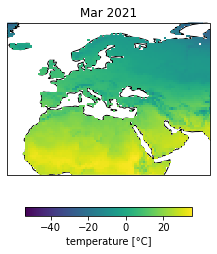

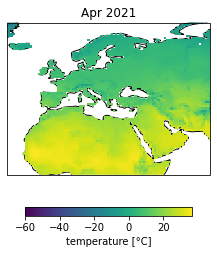

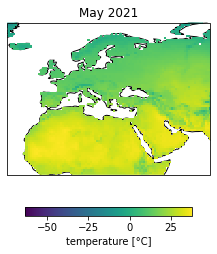

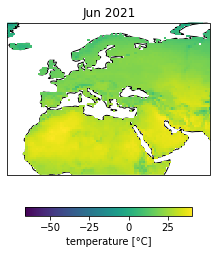

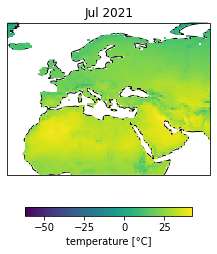

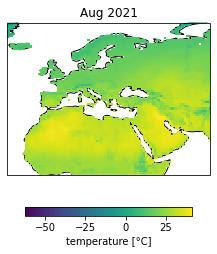

In [15]:
# The data is defined in lat/lon coordinate system, so PlateCarree() is the
# appropriate transformation choice.
# (https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html)
data_crs = ccrs.PlateCarree()

llon, llat = np.meshgrid(lon, lat)
for i in iplot:
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-25, 70, 5, 70])
    ax.set_title(dtime[i].strftime('%b %Y'))
    ax.add_feature(cfeature.COASTLINE)
    pcm = ax.pcolormesh(lon, lat, t2m[i,:,:]-272.15, # alternatively: ax.contourf()
                        transform=data_crs)
    cb = fig.colorbar(pcm, orientation='horizontal', shrink=0.5)
    cb.set_label('temperature [°C]')
    #cb.ax.tick_params(labelsize='large')
    fig.savefig(f'../figs/dragonflies-catalonia/'+dtime[i].strftime('%Y-%m')+'.png',
                bbox_inches='tight', dpi=600)

IndexError: list index out of range

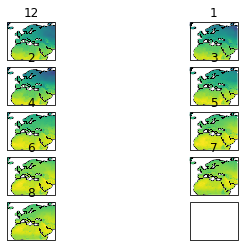

In [9]:
# Following this approach of plotting multiple maps:
# https://cartoee.readthedocs.io/en/latest/examples/cartoee_multimaps.html
# NOTE: deprecated due to small map size on single a4 paper

# The data is defined in lat/lon coordinate system, so PlateCarree() is the
# appropriate transformation choice.
# (https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html)
data_crs = ccrs.PlateCarree()

llon, llat = np.meshgrid(lon, lat)
fig, axs = plt.subplots(nrows=5, ncols=2, # axs has shape (5, 2) -> two loops
                        subplot_kw={'projection': ccrs.PlateCarree()})

counter = 0
for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].set_extent([-25, 65, 5, 70]) # zoom in on Europe, Northern Africa & Middle East
        axs[i,j].set_title(f'{dtime[iplot[counter]].month}')
        axs[i,j].add_feature(cfeature.COASTLINE)
        pcm = axs[i,j].pcolormesh(lon, lat, t2m[iplot[counter],:,:]-272.15, # alternatively: ax.contourf()
                                  transform=data_crs) 
        counter += 1

cb = fig.colorbar(pcm, orientation='horizontal', shrink=0.6)
cb.set_label('temperature [°C]', size=15)
cb.ax.tick_params(labelsize='large')
plt.tight_layout()